In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

Cargamos los datos desde el archivo [`acelerometro.txt`](https://raw.githubusercontent.com/gfrubi/Lab/master/notebooks/acelerometro.txt), que contiene 4 columnas: tiempo $t$, y componentes $x$, $y$ y $z$ de la aceleración de gravedad, respectivamente (en unidades que por ahora ignoraremos).

Estos datos han sido registrados por un celular, usando la aplicación
[Physics Toolbox Sensor Suite (Android)](https://play.google.com/store/apps/details?id=com.chrystianvieyra.physicstoolboxsuite).

In [2]:
data = genfromtxt('acelerometro.txt',skip_header=True, delimiter=',')

Trabajaremos con los valores de $a_z$ (cuarta columna), y graficamos sus valores en función del tiempo $t$:

In [3]:
t = data[:,0]
az = data[:,3]

Text(0,0.5,'$a_z$')

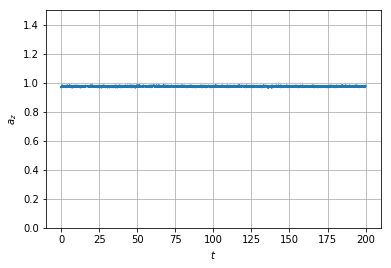

In [4]:
plot(t,az)
grid()
ylim(0,1.5)
xlabel('$t$')
ylabel('$a_z$')

Como vemos, el instrumento no registra un único valor de $a_z$, sino que se presentan fluctuaciones en torno a un valor central. Podemos apreciar mayor detalle al concentrarnos en un intervalo apropiado:

Text(0,0.5,'$a_z$')

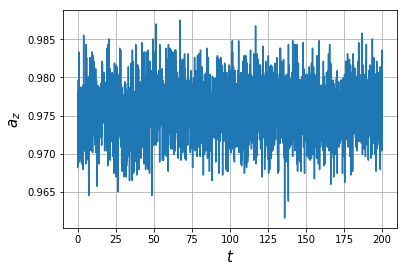

In [5]:
plot(t,az)
grid()
xlabel('$t$', fontsize=15)
ylabel('$a_z$', fontsize=15)

Podemos caracterizar estas fluctuaciones calculando el valor promedio de los $a_z$ registrados, así como su desviación estándar:

In [6]:
mu = mean(az)
s = std(az, ddof=1)
print('Promedio = '+ str(mu))
print('Desviación estándar = '+str(s))

Promedio = 0.975583514176
Desviación estándar = 0.00345438957009


Además, es muy útil confeccionar un histograma de los valores medidos, es decir un conteo del número de veces que se repiden los valores de $a_z$ dentro de intervalos que elijamos. Para esto, usamos la función `hist` de Matplotlib:

Text(0,0.5,'repeticiones')

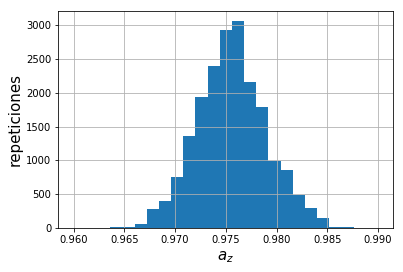

In [7]:
min = 0.96
max = 0.99
Nv = 25
Dx = (max-min)/Nv
xx = linspace(min,max,Nv+1)

hist(az,xx,align='mid',label='Datos')[2]
grid()
xlabel('$a_z$', fontsize=15)
ylabel('repeticiones', fontsize=15)

Lo anterior calcula y grafica el conteo de repeticiones de valores de $a_z$ en el intervalo $[0.96, 0.99]$, dividido en 25 "ventanas" iguales.

Vemos que la distribución de frecuencias es bastante simétrica respecto al valor más frecuente y que los valores más repetidos coinciden aproximadamente con el valor del promedio antes calculado.

A continuación, comparamos estos datos con los valores esperados asumiendo una distribución de probabilidad normal:

In [8]:
from scipy.stats import norm

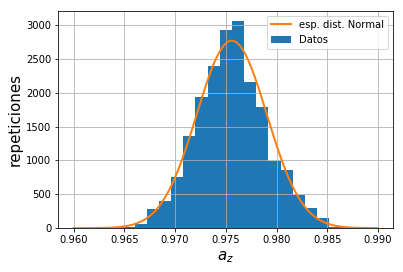

In [9]:
hist(az,xx,align='mid',label='Datos')[2]
xxx = linspace(min,max,100)
plot(xxx,Dx*len(az)*norm.pdf(xxx,scale=s, loc=mu),lw=2, label='esp. dist. Normal')
grid()
xlabel('$a_z$', fontsize=15)
ylabel('repeticiones', fontsize=15)
legend()

Adoptando como modelo para la distribución de probabilidad de los valores de $a_z$ que registra el acelerómetro, podemos respondar distintos tipos de preguntas, tales como: **¿cuál es la probabilidad de que el acelerómetro registre un valor para $a_z$ mayor que 0.988?**

Podemos respondere esto como sigue: Como la función de probabilidad acumulada ("cdf= cumulative distribution function") es definida por
$$
cdf(x)=P(X<x)=\int_{-\infty}^x f(x)\,dx,
$$
entonces la probabilidad $P(X>x)$ es dada por
$$
P(X>x)=1-cdf(x).
$$
Usaremos esta propiedad y la función `norm.cdf` cd scipy.stats para calcular lo pedido:

In [10]:
P = 1-norm.cdf(0.988,scale=s, loc=mu)
print(P)

0.0001625649444


Esto equivale a un $0.016$%. 

Note que el valor deseado puede calcularse directamente usando la "survival function", $sf(x):=1-cdf(x)$, implementada en `norm.sf`:

In [11]:
norm.sf(0.988,scale=s, loc=mu)

0.00016256494439960523

Por supuesto, también podemos obtener lo mismo calculando numéricamente la integral de la densidad de probabilidad:

In [12]:
from scipy.integrate import quad
def f(x):
    return norm.pdf(x,scale=s, loc=mu)

In [13]:
P = quad(f,0.988,inf)[0]
P

0.00016256494439960317

Otra predicción útil que podemos realizar es calcular el ancho $\Delta a_z$ que garantiza una probabilidad, por ejemplo, del 90% de que el sensor registre un valor en el intervalo $\bar{a}_z\pm\Delta a_z$.

Para calcular este intervalo necesitamos encontrar $\Delta a_z$ tal que la probabilidad de encontrar un valor en el intervalo $\bar{a}_z\pm\Delta a_z$ sea de un 90%. Esto significa que requerimos
$$
P(\bar{a}_z-\Delta a_z < X < \bar{a}_z+\Delta a_z) = \int_{\bar{a}_z-\Delta a_z}^{\bar{a}_z+\Delta a_z}f(x)\,dx = 0.9.
$$
Podemos plantear el problema como una ecuación para $\Delta a_z$, definida por $g(\Delta a_z)=0$, con
$$
g(\Delta a_z):= \int_{\bar{a}_z-\Delta a_z}^{\bar{a}_z+\Delta a_z}f(z)\,dz - 0.9.
$$

In [14]:
def g(Dz):
    return quad(f,mu-Dz,mu+Dz)[0]-0.9

Resolvemos numéricamente la ecuación usanso la función `fsolve` de scipy.optimize:

In [15]:
from scipy.optimize import fsolve

In [16]:
solucion = fsolve(g,2*s)
print(solucion)

[ 0.00568197]


En lo anterior, usamos como valor inicial para la búsqueda nuḿerica el valor $2\sigma$ que, como sabemos corresponde aproximadamente al 95%. Con esto, el intervalo requerido es:

In [17]:
print('desde '+str(mu-solucion[0]) + ' hasta '+str(mu+solucion[0]))

desde 0.969901548962 hasta 0.981265479389


Como el cálculo anterior (es decir, encontrar el intervalo centrado en el valor medio que tiene una cierta probabilidad dada) es una tarea común, esto ya está implementado en scipy.stats, a través del método `.interval`. En nuestro caso, simplemente requerimos introducir el siguiente comando:

In [18]:
norm.interval(0.9,scale=s, loc=mu)

(0.96990154896244996, 0.98126547938896758)